In [1]:
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from sklearn.metrics import mean_absolute_percentage_error
import pandas as pd
import numpy as np
from tsxv.splitTrainValTest import split_train_val_test_forwardChaining
import matplotlib.pyplot as plt
import optuna

In [2]:
data = pd.read_csv('BrentOilPrices.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
data = data.resample('M').mean()
data = data.reset_index()

In [3]:
input_train, forecast_train, input_val, forecast_val, input_test, forecast_test = split_train_val_test_forwardChaining(
    data['Date'], numInputs=60, numOutputs=24, numJumps=24)
data = data.set_index('Date')

## Exponential Smoothing

Exponential smoothing is a time series model that provides more weightage to recent observations than past observations.

Three types of exponential smoothing models available:

1. Simple exponential smoothing: Doesn't account for trend and seasonality, resulting in constant predictions.

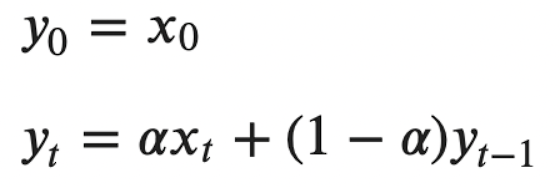

where a represents level (average) of time series data.

2. Double exponential smoothing: Accounts for trend which can be either additive or multiplicative

<img src= "https://miro.medium.com/max/828/1*GtUcDLKCF9-vGixEGFSFlQ.png" width="600">

<b>Note that setting damped_trend to True reduces the effect of trend over time, which is helpful when the trend isn’t expected to grow indefinitely at the current rate</b>.

3. Triple exponential smoothing: Accounts for both trend and seasonality which can be either additive or multiplicative.

<img src= "https://miro.medium.com/max/828/1*LSv1WT3GuCWQdhjL_gNWBw.png" width="600">

<b>Assumptions of exponential smoothing</b>: No assumptions required

<b>Advantages of exponential smoothing</b>:
1. Alogrithm is explicit and easy to be understood.
2. Quick computation.
3. More weight given on recent data.
4. Good at short-term forecasts.

<b>Disadvantages of exponential smoothing</b>:
1. Research required on finding initial values
2. Less suitable for mid-term and long-term forecasts
3. Can't add explanotary variables
4. Can only construct point prediction, not prediction interval

<b>Important hyperparameters of exponential smoothing</b>:
1. trend: Type of trend component
2. seasonal: Type of seasonal component
3. seasonal_periods: Number of periods in a complete seasonal cycle

In [4]:
def es_objective(trial, train_data, val_data=None):
    trend = trial.suggest_categorical('trend',['add','mul',None])
    seasonal = trial.suggest_categorical('seasonal',['add','mul',None])
    seasonal_periods = 0 if seasonal is None else 12
    reg = ExponentialSmoothing(endog=train_data, seasonal=seasonal, seasonal_periods=seasonal_periods, trend=trend, freq='M')
    reg = reg.fit()
    if val_data is not None:
        yhat = reg.forecast(len(val_data))
        val_mape = mean_absolute_percentage_error(val_data,yhat)
    else:
        yhat = reg.predict(start=0, end=len(train_data)-1)
        val_mape = mean_absolute_percentage_error(train_data,yhat)
    return val_mape

In [5]:
avg_val_mape, avg_test_mape = [], []
for fold in range(len(input_train)):
    input_sub_train_data = data.loc[list(input_train[fold].ravel())].drop_duplicates()
    input_sub_val_data = data.loc[list(input_val[fold].ravel())].drop_duplicates()
    input_sub_test_data = data.loc[list(input_test[fold].ravel())].drop_duplicates()
    func = lambda trial: es_objective(trial, input_sub_train_data, input_sub_val_data)
    sampler = optuna.samplers.TPESampler(multivariate=True, seed=120)
    study = optuna.create_study(direction='minimize',sampler=sampler)
    study.optimize(func, n_trials=20, gc_after_trial=True, show_progress_bar=True)
    trial = study.best_trial
    seasonal_periods = 0 if trial.params['seasonal'] is None else 12
    reg = ExponentialSmoothing(endog=pd.concat([input_sub_train_data,input_sub_val_data]), seasonal=trial.params['seasonal'], 
                               seasonal_periods=seasonal_periods, trend=trial.params['trend'], freq='M')
    reg = reg.fit()
    yhat = reg.forecast(len(input_sub_test_data))
    test_mape = mean_absolute_percentage_error(input_sub_test_data,yhat)
    print()
    print(f'Best hyperparameters identified for fold {fold+1}: {trial.params}')
    print(f'Validation MAPE for fold {fold+1} : {trial.value}')
    print(f'Test MAPE for fold {fold+1} : {test_mape}')
    print()
    avg_val_mape.append(trial.value)
    avg_test_mape.append(test_mape)
print('---------')
print(f'Average validation MAPE: {np.mean(avg_val_mape)}')
print(f'Average test MAPE: {np.mean(avg_test_mape)}')

[I 2022-11-12 09:57:03,131] A new study created in memory with name: no-name-abd5ca3e-069c-4cc9-8b2f-fc3f9d4660ea


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2022-11-12 09:57:03,191] Trial 0 finished with value: 2.755649806225402 and parameters: {'trend': 'add', 'seasonal': None}. Best is trial 0 with value: 2.755649806225402.
[I 2022-11-12 09:57:03,384] Trial 1 finished with value: 1.3653326022462344 and parameters: {'trend': 'add', 'seasonal': 'mul'}. Best is trial 1 with value: 1.3653326022462344.
[I 2022-11-12 09:57:03,504] Trial 2 finished with value: 0.2519492686497518 and parameters: {'trend': 'mul', 'seasonal': None}. Best is trial 2 with value: 0.2519492686497518.
[I 2022-11-12 09:57:03,608] Trial 3 finished with value: 2.755649806225402 and parameters: {'trend': 'add', 'seasonal': None}. Best is trial 2 with value: 0.2519492686497518.
[I 2022-11-12 09:57:03,731] Trial 4 finished with value: 0.17715239131333782 and parameters: {'trend': None, 'seasonal': 'add'}. Best is trial 4 with value: 0.17715239131333782.
[I 2022-11-12 09:57:04,018] Trial 5 finished with value: 0.21221200163017126 and parameters: {'trend': 'mul', 'seasonal'

[I 2022-11-12 09:57:06,132] A new study created in memory with name: no-name-6f4032a5-a29e-4d8e-a06e-f9781043f8f8



Best hyperparameters identified for fold 1: {'trend': None, 'seasonal': 'mul'}
Validation MAPE for fold 1 : 0.1764570864025147
Test MAPE for fold 1 : 0.3858135079295785



  0%|          | 0/20 [00:00<?, ?it/s]

[I 2022-11-12 09:57:06,185] Trial 0 finished with value: 1.789962771898601 and parameters: {'trend': 'add', 'seasonal': None}. Best is trial 0 with value: 1.789962771898601.
[I 2022-11-12 09:57:06,379] Trial 1 finished with value: 0.2918083727969895 and parameters: {'trend': 'add', 'seasonal': 'mul'}. Best is trial 1 with value: 0.2918083727969895.
[I 2022-11-12 09:57:06,501] Trial 2 finished with value: 0.28891926711836086 and parameters: {'trend': 'mul', 'seasonal': None}. Best is trial 2 with value: 0.28891926711836086.
[I 2022-11-12 09:57:06,607] Trial 3 finished with value: 1.789962771898601 and parameters: {'trend': 'add', 'seasonal': None}. Best is trial 2 with value: 0.28891926711836086.
[I 2022-11-12 09:57:06,723] Trial 4 finished with value: 0.29854380407973974 and parameters: {'trend': None, 'seasonal': 'add'}. Best is trial 2 with value: 0.28891926711836086.
[I 2022-11-12 09:57:07,028] Trial 5 finished with value: 0.2885229542004442 and parameters: {'trend': 'mul', 'seasona

[I 2022-11-12 09:57:10,535] A new study created in memory with name: no-name-5f9442f1-d88a-49e9-8128-b2a9afb397bb



Best hyperparameters identified for fold 2: {'trend': 'mul', 'seasonal': 'mul'}
Validation MAPE for fold 2 : 0.2885229542004442
Test MAPE for fold 2 : 0.2744661964917391



  0%|          | 0/20 [00:00<?, ?it/s]

[I 2022-11-12 09:57:10,598] Trial 0 finished with value: 0.20339293296647085 and parameters: {'trend': 'add', 'seasonal': None}. Best is trial 0 with value: 0.20339293296647085.
[I 2022-11-12 09:57:10,805] Trial 1 finished with value: 0.43206604402682935 and parameters: {'trend': 'add', 'seasonal': 'mul'}. Best is trial 0 with value: 0.20339293296647085.
[I 2022-11-12 09:57:10,930] Trial 2 finished with value: 0.4675342448325741 and parameters: {'trend': 'mul', 'seasonal': None}. Best is trial 0 with value: 0.20339293296647085.
[I 2022-11-12 09:57:11,045] Trial 3 finished with value: 0.20339293296647085 and parameters: {'trend': 'add', 'seasonal': None}. Best is trial 0 with value: 0.20339293296647085.
[I 2022-11-12 09:57:11,168] Trial 4 finished with value: 0.3854115767451137 and parameters: {'trend': None, 'seasonal': 'add'}. Best is trial 0 with value: 0.20339293296647085.
[I 2022-11-12 09:57:11,500] Trial 5 finished with value: 0.455867138717504 and parameters: {'trend': 'mul', 'se

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


[I 2022-11-12 09:57:12,490] Trial 9 finished with value: 0.3452121320741389 and parameters: {'trend': 'mul', 'seasonal': 'add'}. Best is trial 0 with value: 0.20339293296647085.
[I 2022-11-12 09:57:12,684] Trial 10 finished with value: 0.6489253275150173 and parameters: {'trend': 'add', 'seasonal': 'add'}. Best is trial 0 with value: 0.20339293296647085.
[I 2022-11-12 09:57:12,795] Trial 11 finished with value: 0.20339293296647085 and parameters: {'trend': 'add', 'seasonal': None}. Best is trial 0 with value: 0.20339293296647085.
[I 2022-11-12 09:57:12,908] Trial 12 finished with value: 0.20339293296647085 and parameters: {'trend': 'add', 'seasonal': None}. Best is trial 0 with value: 0.20339293296647085.
[I 2022-11-12 09:57:13,003] Trial 13 finished with value: 0.39133202827926833 and parameters: {'trend': None, 'seasonal': None}. Best is trial 0 with value: 0.20339293296647085.
[I 2022-11-12 09:57:13,112] Trial 14 finished with value: 0.20339293296647085 and parameters: {'trend': 'ad

[I 2022-11-12 09:57:13,932] A new study created in memory with name: no-name-0cec6cfc-755a-49e7-bf42-2b9efbf68a57



Best hyperparameters identified for fold 3: {'trend': 'add', 'seasonal': None}
Validation MAPE for fold 3 : 0.20339293296647085
Test MAPE for fold 3 : 0.4729112189695022



  0%|          | 0/20 [00:00<?, ?it/s]

[I 2022-11-12 09:57:14,006] Trial 0 finished with value: 0.217778232113699 and parameters: {'trend': 'add', 'seasonal': None}. Best is trial 0 with value: 0.217778232113699.
[I 2022-11-12 09:57:14,213] Trial 1 finished with value: 0.20693836415141822 and parameters: {'trend': 'add', 'seasonal': 'mul'}. Best is trial 1 with value: 0.20693836415141822.
[I 2022-11-12 09:57:14,343] Trial 2 finished with value: 0.28584586832392206 and parameters: {'trend': 'mul', 'seasonal': None}. Best is trial 1 with value: 0.20693836415141822.
[I 2022-11-12 09:57:14,460] Trial 3 finished with value: 0.217778232113699 and parameters: {'trend': 'add', 'seasonal': None}. Best is trial 1 with value: 0.20693836415141822.
[I 2022-11-12 09:57:14,587] Trial 4 finished with value: 0.23241305554910785 and parameters: {'trend': None, 'seasonal': 'add'}. Best is trial 1 with value: 0.20693836415141822.
[I 2022-11-12 09:57:14,960] Trial 5 finished with value: 0.25942883531997446 and parameters: {'trend': 'mul', 'seas

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


[I 2022-11-12 09:57:16,011] Trial 9 finished with value: 0.33950891915608794 and parameters: {'trend': 'mul', 'seasonal': 'add'}. Best is trial 1 with value: 0.20693836415141822.
[I 2022-11-12 09:57:16,228] Trial 10 finished with value: 0.20693836415141822 and parameters: {'trend': 'add', 'seasonal': 'mul'}. Best is trial 1 with value: 0.20693836415141822.
[I 2022-11-12 09:57:16,432] Trial 11 finished with value: 0.20693836415141822 and parameters: {'trend': 'add', 'seasonal': 'mul'}. Best is trial 1 with value: 0.20693836415141822.
[I 2022-11-12 09:57:16,637] Trial 12 finished with value: 0.20693836415141822 and parameters: {'trend': 'add', 'seasonal': 'mul'}. Best is trial 1 with value: 0.20693836415141822.
[I 2022-11-12 09:57:16,762] Trial 13 finished with value: 0.2240066759937669 and parameters: {'trend': None, 'seasonal': 'mul'}. Best is trial 1 with value: 0.20693836415141822.
[I 2022-11-12 09:57:16,973] Trial 14 finished with value: 0.21182937735699647 and parameters: {'trend':

[I 2022-11-12 09:57:18,057] A new study created in memory with name: no-name-2acfb317-2f39-44be-aacd-a55cd54cdff6



Best hyperparameters identified for fold 4: {'trend': 'add', 'seasonal': 'mul'}
Validation MAPE for fold 4 : 0.20693836415141822
Test MAPE for fold 4 : 0.20488227301041154



  0%|          | 0/20 [00:00<?, ?it/s]

[I 2022-11-12 09:57:18,118] Trial 0 finished with value: 0.3311514638607631 and parameters: {'trend': 'add', 'seasonal': None}. Best is trial 0 with value: 0.3311514638607631.
[I 2022-11-12 09:57:18,340] Trial 1 finished with value: 0.31946399899128186 and parameters: {'trend': 'add', 'seasonal': 'mul'}. Best is trial 1 with value: 0.31946399899128186.
[I 2022-11-12 09:57:18,475] Trial 2 finished with value: 0.38796693437349816 and parameters: {'trend': 'mul', 'seasonal': None}. Best is trial 1 with value: 0.31946399899128186.
[I 2022-11-12 09:57:18,590] Trial 3 finished with value: 0.3311514638607631 and parameters: {'trend': 'add', 'seasonal': None}. Best is trial 1 with value: 0.31946399899128186.
[I 2022-11-12 09:57:18,716] Trial 4 finished with value: 0.3455590266482521 and parameters: {'trend': None, 'seasonal': 'add'}. Best is trial 1 with value: 0.31946399899128186.
[I 2022-11-12 09:57:19,106] Trial 5 finished with value: 0.35810692897749363 and parameters: {'trend': 'mul', 'se

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


[I 2022-11-12 09:57:20,252] Trial 9 finished with value: 0.48547058808856874 and parameters: {'trend': 'mul', 'seasonal': 'add'}. Best is trial 1 with value: 0.31946399899128186.
[I 2022-11-12 09:57:20,471] Trial 10 finished with value: 0.31946399899128186 and parameters: {'trend': 'add', 'seasonal': 'mul'}. Best is trial 1 with value: 0.31946399899128186.
[I 2022-11-12 09:57:20,684] Trial 11 finished with value: 0.31946399899128186 and parameters: {'trend': 'add', 'seasonal': 'mul'}. Best is trial 1 with value: 0.31946399899128186.
[I 2022-11-12 09:57:20,924] Trial 12 finished with value: 0.31946399899128186 and parameters: {'trend': 'add', 'seasonal': 'mul'}. Best is trial 1 with value: 0.31946399899128186.
[I 2022-11-12 09:57:21,059] Trial 13 finished with value: 0.3396632564988744 and parameters: {'trend': None, 'seasonal': 'mul'}. Best is trial 1 with value: 0.31946399899128186.
[I 2022-11-12 09:57:21,273] Trial 14 finished with value: 0.32230005239169557 and parameters: {'trend':

[I 2022-11-12 09:57:22,446] A new study created in memory with name: no-name-e13ca7ca-246c-43ef-b123-16e75f0288a0



Best hyperparameters identified for fold 5: {'trend': 'add', 'seasonal': 'mul'}
Validation MAPE for fold 5 : 0.31946399899128186
Test MAPE for fold 5 : 0.23385525494667733



  0%|          | 0/20 [00:00<?, ?it/s]

[I 2022-11-12 09:57:22,510] Trial 0 finished with value: 0.4042708617136 and parameters: {'trend': 'add', 'seasonal': None}. Best is trial 0 with value: 0.4042708617136.
[I 2022-11-12 09:57:22,737] Trial 1 finished with value: 0.38053503915444137 and parameters: {'trend': 'add', 'seasonal': 'mul'}. Best is trial 1 with value: 0.38053503915444137.
[I 2022-11-12 09:57:22,878] Trial 2 finished with value: 0.435740143916094 and parameters: {'trend': 'mul', 'seasonal': None}. Best is trial 1 with value: 0.38053503915444137.
[I 2022-11-12 09:57:22,998] Trial 3 finished with value: 0.4042708617136 and parameters: {'trend': 'add', 'seasonal': None}. Best is trial 1 with value: 0.38053503915444137.
[I 2022-11-12 09:57:23,125] Trial 4 finished with value: 0.42958947238668627 and parameters: {'trend': None, 'seasonal': 'add'}. Best is trial 1 with value: 0.38053503915444137.
[I 2022-11-12 09:57:23,557] Trial 5 finished with value: 0.39929591606151593 and parameters: {'trend': 'mul', 'seasonal': '

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
[I 2022-11-12 09:57:27,272] A new study created in memory with name: no-name-b97787c7-20b0-4654-a54a-4e307408b851



Best hyperparameters identified for fold 6: {'trend': 'add', 'seasonal': 'mul'}
Validation MAPE for fold 6 : 0.38053503915444137
Test MAPE for fold 6 : 0.18285975003475632



  0%|          | 0/20 [00:00<?, ?it/s]

[I 2022-11-12 09:57:27,340] Trial 0 finished with value: 0.20655092552505208 and parameters: {'trend': 'add', 'seasonal': None}. Best is trial 0 with value: 0.20655092552505208.
[I 2022-11-12 09:57:27,579] Trial 1 finished with value: 0.2136424448082538 and parameters: {'trend': 'add', 'seasonal': 'mul'}. Best is trial 0 with value: 0.20655092552505208.
[I 2022-11-12 09:57:27,718] Trial 2 finished with value: 0.5336691077383897 and parameters: {'trend': 'mul', 'seasonal': None}. Best is trial 0 with value: 0.20655092552505208.
[I 2022-11-12 09:57:27,836] Trial 3 finished with value: 0.20655092552505208 and parameters: {'trend': 'add', 'seasonal': None}. Best is trial 0 with value: 0.20655092552505208.
[I 2022-11-12 09:57:27,970] Trial 4 finished with value: 0.20055593887985165 and parameters: {'trend': None, 'seasonal': 'add'}. Best is trial 4 with value: 0.20055593887985165.
[I 2022-11-12 09:57:28,438] Trial 5 finished with value: 0.6455480787930881 and parameters: {'trend': 'mul', 's

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


[I 2022-11-12 09:57:29,693] Trial 9 finished with value: 1.0970984013417089 and parameters: {'trend': 'mul', 'seasonal': 'add'}. Best is trial 4 with value: 0.20055593887985165.
[I 2022-11-12 09:57:29,821] Trial 10 finished with value: 0.20055593887985165 and parameters: {'trend': None, 'seasonal': 'add'}. Best is trial 4 with value: 0.20055593887985165.
[I 2022-11-12 09:57:29,953] Trial 11 finished with value: 0.20055593887985165 and parameters: {'trend': None, 'seasonal': 'add'}. Best is trial 4 with value: 0.20055593887985165.
[I 2022-11-12 09:57:30,093] Trial 12 finished with value: 0.20003302474856569 and parameters: {'trend': None, 'seasonal': 'mul'}. Best is trial 12 with value: 0.20003302474856569.
[I 2022-11-12 09:57:30,235] Trial 13 finished with value: 0.20003302474856569 and parameters: {'trend': None, 'seasonal': 'mul'}. Best is trial 12 with value: 0.20003302474856569.
[I 2022-11-12 09:57:30,365] Trial 14 finished with value: 0.20003302474856569 and parameters: {'trend': 

[I 2022-11-12 09:57:31,177] A new study created in memory with name: no-name-b59df685-bbf9-43f4-8faf-59fe9c2a498e


[I 2022-11-12 09:57:31,025] Trial 19 finished with value: 0.20003302474856569 and parameters: {'trend': None, 'seasonal': 'mul'}. Best is trial 12 with value: 0.20003302474856569.

Best hyperparameters identified for fold 7: {'trend': None, 'seasonal': 'mul'}
Validation MAPE for fold 7 : 0.20003302474856569
Test MAPE for fold 7 : 0.5107411140319807



  0%|          | 0/20 [00:00<?, ?it/s]

[I 2022-11-12 09:57:31,245] Trial 0 finished with value: 0.7518475751762764 and parameters: {'trend': 'add', 'seasonal': None}. Best is trial 0 with value: 0.7518475751762764.
[I 2022-11-12 09:57:31,490] Trial 1 finished with value: 0.7044697168992329 and parameters: {'trend': 'add', 'seasonal': 'mul'}. Best is trial 1 with value: 0.7044697168992329.
[I 2022-11-12 09:57:31,641] Trial 2 finished with value: 1.266296832759121 and parameters: {'trend': 'mul', 'seasonal': None}. Best is trial 1 with value: 0.7044697168992329.
[I 2022-11-12 09:57:31,761] Trial 3 finished with value: 0.7518475751762764 and parameters: {'trend': 'add', 'seasonal': None}. Best is trial 1 with value: 0.7044697168992329.
[I 2022-11-12 09:57:31,885] Trial 4 finished with value: 0.3335759600108102 and parameters: {'trend': None, 'seasonal': 'add'}. Best is trial 4 with value: 0.3335759600108102.
[I 2022-11-12 09:57:32,424] Trial 5 finished with value: 1.1752502213119838 and parameters: {'trend': 'mul', 'seasonal':

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


[I 2022-11-12 09:57:33,742] Trial 9 finished with value: 1.9673220013346677 and parameters: {'trend': 'mul', 'seasonal': 'add'}. Best is trial 4 with value: 0.3335759600108102.
[I 2022-11-12 09:57:33,870] Trial 10 finished with value: 0.3335759600108102 and parameters: {'trend': None, 'seasonal': 'add'}. Best is trial 4 with value: 0.3335759600108102.
[I 2022-11-12 09:57:34,003] Trial 11 finished with value: 0.3335759600108102 and parameters: {'trend': None, 'seasonal': 'add'}. Best is trial 4 with value: 0.3335759600108102.
[I 2022-11-12 09:57:34,149] Trial 12 finished with value: 0.3215579623214807 and parameters: {'trend': None, 'seasonal': 'mul'}. Best is trial 12 with value: 0.3215579623214807.
[I 2022-11-12 09:57:34,299] Trial 13 finished with value: 0.3215579623214807 and parameters: {'trend': None, 'seasonal': 'mul'}. Best is trial 12 with value: 0.3215579623214807.
[I 2022-11-12 09:57:34,446] Trial 14 finished with value: 0.3215579623214807 and parameters: {'trend': None, 'sea

In [6]:
func = lambda trial: es_objective(trial, data)
sampler = optuna.samplers.TPESampler(multivariate=True, seed=120)
study = optuna.create_study(direction='minimize',sampler=sampler)
study.optimize(func, n_trials=20, gc_after_trial=True, show_progress_bar=True)
trial = study.best_trial

[I 2022-11-12 09:57:35,285] A new study created in memory with name: no-name-77bf014e-0059-4bb9-b232-b00edfb22fa6


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2022-11-12 09:57:35,351] Trial 0 finished with value: 0.07229378583113037 and parameters: {'trend': 'add', 'seasonal': None}. Best is trial 0 with value: 0.07229378583113037.
[I 2022-11-12 09:57:35,624] Trial 1 finished with value: 0.07212609640536546 and parameters: {'trend': 'add', 'seasonal': 'mul'}. Best is trial 1 with value: 0.07212609640536546.
[I 2022-11-12 09:57:35,795] Trial 2 finished with value: 0.07214760107300762 and parameters: {'trend': 'mul', 'seasonal': None}. Best is trial 1 with value: 0.07212609640536546.
[I 2022-11-12 09:57:35,915] Trial 3 finished with value: 0.07229378583113037 and parameters: {'trend': 'add', 'seasonal': None}. Best is trial 1 with value: 0.07212609640536546.
[I 2022-11-12 09:57:36,049] Trial 4 finished with value: 0.07231912139230219 and parameters: {'trend': None, 'seasonal': 'add'}. Best is trial 1 with value: 0.07212609640536546.
[I 2022-11-12 09:57:36,749] Trial 5 finished with value: 0.07203052283738143 and parameters: {'trend': 'mul',

In [7]:
seasonal_periods = 12 if trial.params['seasonal'] is not None else 0
reg = ExponentialSmoothing(endog=data, seasonal=trial.params['seasonal'], seasonal_periods=seasonal_periods, 
                           trend=trial.params['trend'], freq='M')
reg = reg.fit()
pred_values = reg.predict(start=0, end=len(data)-1)

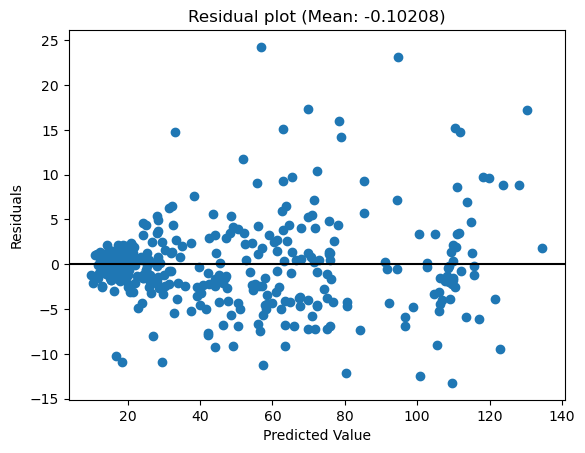

In [8]:
plt.scatter(x = pred_values, y= np.subtract(pred_values,data['Price']))
plt.axhline(y=0, color='black')
plt.title(f"Residual plot (Mean: {np.round(np.subtract(pred_values,data['Price']).mean(),6)})")
plt.ylabel('Residuals')
plt.xlabel('Predicted Value')
plt.show()

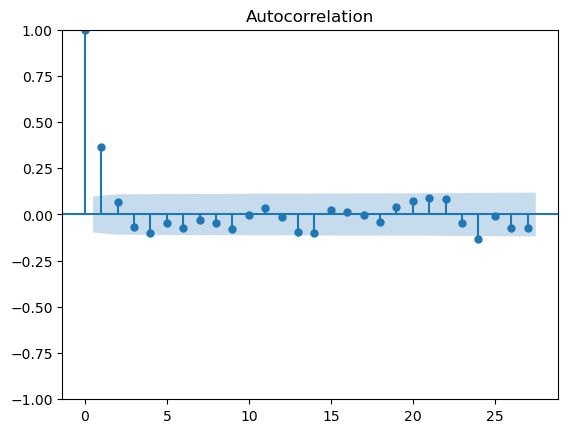

array([ 1.00000000e+00,  3.62901815e-01,  6.67151653e-02, -6.97976535e-02,
       -1.00307572e-01, -4.72573876e-02, -7.40972523e-02, -2.82124304e-02,
       -4.70348412e-02, -7.60238908e-02, -6.83085703e-04,  3.66205100e-02,
       -1.58776727e-02, -9.45435764e-02, -9.98306802e-02,  2.52564827e-02,
        1.60650482e-02, -3.08288809e-04, -3.95349344e-02,  3.88073580e-02,
        7.20951334e-02,  8.99759141e-02,  8.40310577e-02, -4.57561007e-02,
       -1.30778989e-01, -7.86905915e-03, -7.32533465e-02])

In [9]:
plot_acf(np.subtract(pred_values,data['Price']))
plt.show()
acf(np.subtract(pred_values,data['Price']))

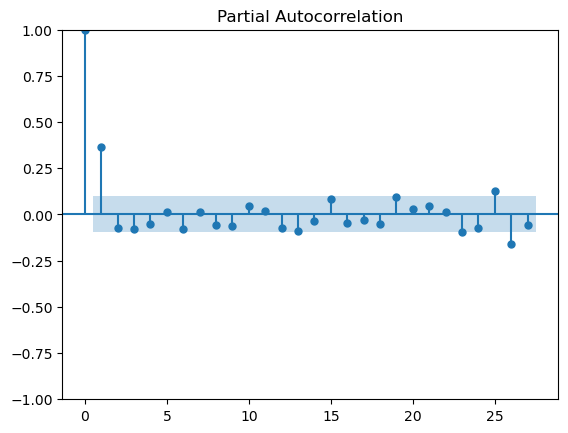

array([ 1.        ,  0.36380009, -0.0752657 , -0.08016852, -0.0491328 ,
        0.01112498, -0.0775216 ,  0.01475665, -0.0545721 , -0.06270075,
        0.0472594 ,  0.02048836, -0.07243668, -0.09119776, -0.03607268,
        0.08428218, -0.04561092, -0.02752736, -0.05308165,  0.09276884,
        0.03110112,  0.0477843 ,  0.01533078, -0.09632913, -0.07516726,
        0.12644672, -0.15873666])

In [10]:
plot_pacf(np.subtract(pred_values,data['Price']))
plt.show()
pacf(np.subtract(pred_values,data['Price']))

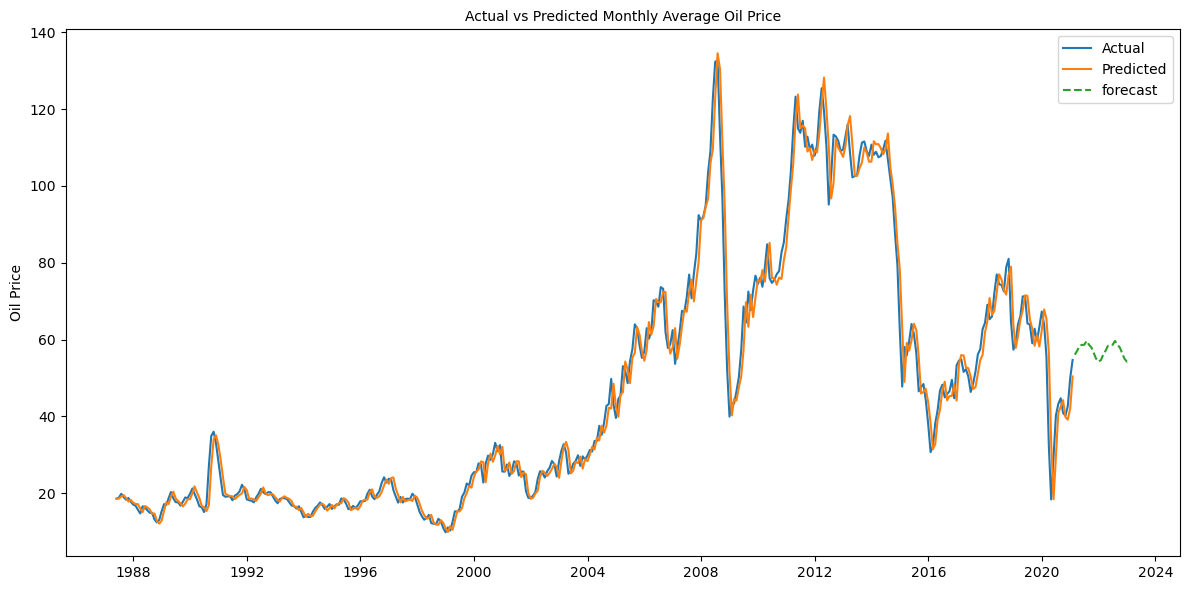

In [11]:
plt.figure(figsize=(12,6))
plt.plot(data, label='Actual')
plt.title('Actual vs Predicted Monthly Average Oil Price', fontsize=10)
pred_data = pd.DataFrame({'Date':data.reset_index()['Date'],'Price': pd.Series(pred_values.reset_index(drop=True))})
pred_data['Date'] = pd.to_datetime(pred_data['Date'])
pred_data = pred_data.set_index('Date')
plt.plot(pred_data, label='Predicted')
forecast_data = reg.forecast(24)
plt.plot(forecast_data, label='forecast',linestyle='--')
plt.legend(loc='best')
plt.ylabel("Oil Price")
plt.tight_layout()